# Playground Notebook For Quantizing VLP Models

In [6]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import torch.quantization
import pytorch_lightning as pl
import copy
import random
random.seed(42)

# Model Specific imports
from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
from meter.datamodules.multitask_datamodule import MTDataModule as MTDataModuleMETER
from vilt.modules import ViLTransformerSS
from meter.modules import METERTransformerSS

# Custom imports
import configs
from quantization_utils import get_quantization_config
from quantization_utils import  SmallMTDataModuleMETER, SmallMTDataModuleVILT

from torchao.quantization.prototype.qat import Int8DynActInt4WeightQATQuantizer
import quantization_utils
import configs
from vilt.modules.kd_module import NLVR2LightningModel



In [2]:
import os
# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "9"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "9"  # Set this to the number of CPUs you want to use

# Configurations

In [3]:
# Set the configuration
_config = configs.vilt_config_nlvr2
_config["batch_size"] = 18
_config["per_gpu_batchsize"] = 18
_config["learning_rate"] = 0.001

# Set the PyTorch Lightning seed
pl.seed_everything(_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use

# Set environment variables
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

Seed set to 0


## Initialize Distributed Backend

In [4]:
import torch.distributed as dist
# Initialize the process group
dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

# Verify initialization
print(f"Initialized: {dist.is_initialized()}")

Initialized: True


## Define helper functions

In [5]:
def print_size_of_model(model):
    """
    Function to print the size of the model.

    Args:
        model (torch.nn.Module): The model to get the size
    
    Returns:
        None
    """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

# Initialize the Datamodule

In [9]:
# ==========================================
# ========= Create full datamodule =========
# ==========================================
if "meter" in _config["model"]:
    full_dm = MTDataModuleMeter(_config, dist=False)
    
    test_dm = SmallMTDataModuleMETER(_config, dist=False, percentage=0.1)
    test_dm.setup("test", is_random=True)
    test_dataloader = test_dm.test_dataloader()
    
    fine_tune_dm = SmallMTDataModuleMETER(_config, dist=False, percentage=0.5)
    # fine_tune_dm = SmallMTDataModuleMETER(_config, dist=False, num_samples=8, start_idx=0)
    fine_tune_dm.setup("fit", is_random=True)
    fine_tune_dataloader = fine_tune_dm.test_dataloader()
    

elif "vilt" in _config["model"]:
    full_dm = MTDataModuleVILT(_config, dist=False)

    test_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=50)
    test_dm.setup("test", is_random=True)
    test_dataloader = test_dm.test_dataloader()

    fine_tune_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=50)
    fine_tune_dm.setup("test", is_random=True)
    fine_tune_dataloader = fine_tune_dm.test_dataloader()

else:
    raise ValueError("Model not supported: ", _config["model"])

print(f"Batch size: {_config['batch_size']}")
print(f"Lenght of the finetune dataloader: {len(fine_tune_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Batch size: 18
Lenght of the finetune dataloader: 3
Length of test dataloader: 3


# Initialize The Model

In [6]:
if _config["model"] == "vilt":
    model = ViLTransformerSS(_config)
    print("Initialized ViLT model")

elif _config["model"] == "meter":
    model = METERTransformerSS(_config)
    print("Initialized METER model")

else:
    raise ValueError("Model not supported: ", _config["model"])

Initialized ViLT model


# Initialize The Trainer

In [7]:
# ========== Initialize the trainer for full precision ==========
def init_trainer(_config, accelerator, num_devices, max_epochs, max_steps):
    exp_name = f'{_config["exp_name"]}'

    os.makedirs(_config["log_dir"], exist_ok=True)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=1,
        verbose=True,
        monitor="val/the_metric",
        mode="max",
        save_last=True,
    )
    logger = pl.loggers.TensorBoardLogger(
        _config["log_dir"],
        name=f'{exp_name}_seed{_config["seed"]}_from_{_config["load_path"].split("/")[-1][:-5]}',
    )

    lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="step")
    # callbacks = [lr_callback]
    callbacks = [checkpoint_callback, lr_callback]

    num_gpus = (
        _config["num_gpus"]
        if isinstance(_config["num_gpus"], int)
        else len(_config["num_gpus"])
    )

    grad_steps = max(_config["batch_size"] // (
        _config["per_gpu_batchsize"] * num_gpus * _config["num_nodes"]
    ), 1)

    # max_steps = _config["max_steps"] if _config["max_steps"] is not None else None


    trainer = pl.Trainer(
            accelerator=accelerator,
            devices=num_devices,
            num_nodes=_config["num_nodes"],
            precision=_config["precision"],
            # strategy="ddp",
            benchmark=True,
            deterministic=False,
            max_epochs=max_epochs,
            max_steps=max_steps,
            callbacks=callbacks,
            logger=logger,
            accumulate_grad_batches=grad_steps,
            log_every_n_steps=10,
            fast_dev_run=_config["fast_dev_run"],
            val_check_interval=_config["val_check_interval"],
        )
    
    return trainer

trainer = init_trainer(_config, accelerator="gpu", num_devices=1, max_epochs=3, max_steps=50000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


# Dynamic Quantization Functions

In [8]:
def create_quantization_config_dict(bits, module_name_list):
    """
    Creates a dictionary of quantization configurations for specific modules in a model.
    
    Args:
        bits (int): The number of bits to quantize the model to. Available options are 8, 4, and 2.
        module_name_list (list of str): A list of module names (or dot-separated paths) within the model to quantize.
        
    Returns:
        dict: A dictionary of quantization configurations for the specified modules.
    """

    quantization_config, embedding_config = get_quantization_config(bits)
    modules_config = {}

    for module_name in module_name_list:
        if "embedding" in module_name:
            modules_config[module_name] = embedding_config
        else:
            modules_config[module_name] = quantization_config
    
    return modules_config


def quantize_modules(model, bits, module_name_list, inplace=True):
    """
    Quantizes specific modules in a deep copy of the input model using dynamic quantization.

    Args:
        model (torch.nn.Module): The PyTorch model to quantize.
        bits (int): The number of bits to quantize the model to. Available options are 8, 4, and 2.
        module_names_to_quantize (list of str): A list of module names (or dot-separated paths)
                                                 within the model to apply dynamic quantization to.

    Returns:
        torch.nn.Module: A deep copy of the input model with specified modules dynamically quantized.
                         Returns None if no modules are provided to quantize.
    """

    modules_config = create_quantization_config_dict(bits, module_name_list)

    model_quantized = deepcopy(model)
    
    
    torch.quantization.quantize_dynamic(
        model_quantized, modules_config, inplace=True
    )

    return model_quantized

def print_frozen_layers(model):
    """
    Prints the names of the layers in a PyTorch model and whether they are frozen or not.
    
    Args:
        model (nn.Module): The PyTorch model to print the frozen status of.
    """

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Frozen: {not param.requires_grad}")


def freeze_except_layers(model, layers_to_unfreeze_names):
    """
    Freezes all parameters of a PyTorch model except for the layers specified by their names.

    Args:
        model (nn.Module): The PyTorch model to freeze parameters in.
        layers_to_unfreeze_names (list of str): A list of module names that should NOT be frozen.
                                             Parameters in modules whose names contain these strings will be unfrozen.
    """
    for name, param in model.named_parameters():
        freeze = True  # Initially assume we should freeze the parameter
        for layer_name_to_unfreeze in layers_to_unfreeze_names:
            if layer_name_to_unfreeze in name:
                freeze = False  # Unfreeze if the name contains a layer to unfreeze
                break  # No need to check other layer names if already unfrozen

        if freeze:
            param.requires_grad = False  # Freeze the parameter
        else:
            param.requires_grad = True   # Ensure it's unfrozen (explicitly set to True)

    # Optional: Print which layers are frozen and unfrozen for verification
    print_frozen_layers(model)

# QAT Analysis

In [9]:
modules_to_quantize = [
    "text_transformer.encoder.layer.2.output.dense",
    "text_transformer.encoder.layer.2.intermediate.dense",
    # "text_transformer.encoder.layer.3.output.dense",
    # "text_transformer.encoder.layer.3.intermediate.dense"
]


# Quantizer for int8 dynamic per token activations +
# int4 grouped per channel weights, only for linear layers
qat_quantizer = Int8DynActInt4WeightQATQuantizer()

# Insert "fake quantize" operations into linear layers.
# These operations simulate quantization numerics during
# training without performing any dtype casting
model = qat_quantizer.prepare(model)

# Freeze all layers except the ones to be quantized
print(f"Freezing all layers except: {modules_to_quantize}")
freeze_except_layers(model, modules_to_quantize)

Inside Int8DynActInt4WeightQATQuantizer
Inside Int8DynActInt4WeightQATQuantizer.prepare
Inside of _replace_linear_8da4w fucntion from GPTQ script
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT replaced with replacement_fn
model is NOT r

In [10]:
print(model)

METERTransformerSS(
  (cross_modal_text_transform): Linear(in_features=768, out_features=768, bias=True)
  (cross_modal_image_transform): Linear(in_features=768, out_features=768, bias=True)
  (token_type_embeddings): Embedding(3, 768)
  (vit_model): CLIP(
    (visual): VisualTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  

In [11]:
# Count the number of parameters in the model that requires gradients
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in Millons: {num_params/1e6}")

Number of parameters in Millons: 4.718592


# Training analysis

In [12]:
trainer.fit(model, fine_tune_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_classifier            | Sequential   | 4.7 M  | train
10 | train_nlvr2_accuracy        | Accuracy     | 0      | train
11 | train_nlvr2_loss            | Scalar       | 0      | train
12 | dev_nlvr2_accuracy          | Accu

Epoch 0:   0%|          | 0/89 [00:00<?, ?it/s]                            

OutOfMemoryError: CUDA out of memory. Tried to allocate 156.00 MiB. GPU 0 has a total capacity of 11.90 GiB of which 102.44 MiB is free. Including non-PyTorch memory, this process has 11.79 GiB memory in use. Of the allocated memory 11.31 GiB is allocated by PyTorch, and 309.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
# import sys
# import torch

# torch.set_printoptions(threshold=sys.maxsize)

In [10]:
# layer_to_analzye = [
#     "text_transformer.encoder.layer.2.output.dense",
#     "text_transformer.encoder.layer.2.intermediate.dense",
# ]

# freeze_except_layers(model, layer_to_analzye)

fc1_weight = model.text_transformer.encoder.layer[2].intermediate.dense.weight.clone()
fc2_weight = model.text_transformer.encoder.layer[2].output.dense.weight.clone()
fc2_bias = model.text_transformer.encoder.layer[2].output.dense.bias.clone()

ref_weight = model.text_transformer.encoder.layer[0].intermediate.dense.weight.clone()

print(f"FV1 weight shape: {fc1_weight.shape}")
print(f"FC2 weight shape: {fc2_weight.shape}")
print(f"FC2 bias shape: {fc2_bias.shape}")
print(f"Ref weight shape: {ref_weight.shape}")

FV1 weight shape: torch.Size([3072, 768])
FC2 weight shape: torch.Size([768, 3072])
FC2 bias shape: torch.Size([768])
Ref weight shape: torch.Size([3072, 768])


In [11]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW, Adam, SGD
from transformers import get_cosine_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup

def print_frozen_layers(model):
    """
    Prints the names of the layers in a PyTorch model and whether they are frozen or not.
    
    Args:
        model (nn.Module): The PyTorch model to print the frozen status of.
    """

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Frozen: {not param.requires_grad}")


def freeze_except_layers(model, layers_to_unfreeze_names):
    """
    Freezes all parameters of a PyTorch model except for the layers specified by their names.

    Args:
        model (nn.Module): The PyTorch model to freeze parameters in.
        layers_to_unfreeze_names (list of str): A list of module names that should NOT be frozen.
                                             Parameters in modules whose names contain these strings will be unfrozen.
    """
    for name, param in model.named_parameters():
        freeze = True  # Initially assume we should freeze the parameter
        for layer_name_to_unfreeze in layers_to_unfreeze_names:
            if layer_name_to_unfreeze in name:
                freeze = False  # Unfreeze if the name contains a layer to unfreeze
                break  # No need to check other layer names if already unfrozen

        if freeze:
            param.requires_grad = False  # Freeze the parameter
        else:
            param.requires_grad = True   # Ensure it's unfrozen (explicitly set to True)

    # Optional: Print which layers are frozen and unfrozen for verification
    print_frozen_layers(model)

def compute_nlvr2(pl_module, batch):
    infer1 = pl_module.infer(
        batch, mask_text=False, mask_image=False, image_token_type_idx=1
    )
    infer2 = pl_module.infer(
        batch, mask_text=False, mask_image=False, image_token_type_idx=2
    )

    cls_feats = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)
    nlvr2_logits = pl_module.nlvr2_classifier(cls_feats)

    nlvr2_labels = batch["answers"]
    nlvr2_labels = torch.tensor(nlvr2_labels).to(pl_module.device).long()
    nlvr2_loss = F.cross_entropy(nlvr2_logits, nlvr2_labels)

    ret = {
        "nlvr2_loss": nlvr2_loss,
        "nlvr2_logits": nlvr2_logits,
        "nlvr2_labels": nlvr2_labels,
    }
    return ret

def set_schedule_simple_optimizer(pl_module, max_steps):
    lr = pl_module.hparams.config["learning_rate"]
    wd = 0.0  # No weight decay for any parameters as requested

    optim_type = "adam" #pl_module.hparams.config["optim_type"]

    # Get all parameters that require gradients
    params_to_optimize = [p for p in pl_module.parameters() if p.requires_grad]

    if optim_type == "adamw":
        optimizer = AdamW(
            params_to_optimize, lr=lr, eps=1e-8, betas=(0.9, 0.98), weight_decay=wd
        )
    elif optim_type == "adam":
        optimizer = Adam(params_to_optimize, lr=lr, weight_decay=wd)
    elif optim_type == "sgd":
        optimizer = SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=wd)

    max_steps = max_steps

    warmup_steps = pl_module.hparams.config["warmup_steps"]
    if isinstance(pl_module.hparams.config["warmup_steps"], float):
        warmup_steps = int(max_steps * warmup_steps)

    decay_power = pl_module.hparams.config["decay_power"]
    end_lr = pl_module.hparams.config["end_lr"]

    if decay_power == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=max_steps,
        )
    else:
        scheduler = get_polynomial_decay_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=max_steps,
            lr_end=end_lr,
            power=decay_power,
        )

    print("Optimizer: ", optimizer)
    print("Warmup steps: ", warmup_steps)
    print("Max steps: ", max_steps)
    print("End LR: ", end_lr)
    print("Decay power: ", decay_power)

    sched = {"scheduler": scheduler, "interval": "step"}

    return (
        [optimizer],
        [sched],
    )


def train_nlvr2_loop(pl_module, train_dataloader, val_dataloader, num_epochs, accumulation_steps, max_steps):
    """
    Training loop for NLVR2 task using a simplified optimizer configuration.

    Args:
        pl_module: The PyTorch Lightning module.
        train_dataloader: PyTorch DataLoader for the training dataset.
        num_epochs: Number of training epochs.
    """

    # Initialize optimizer and scheduler using the simplified config
    optimizers, schedulers = set_schedule_simple_optimizer(pl_module, max_steps)
    print("Optimizer: ", optimizers)
    optimizer = optimizers[0]  # Assuming only one optimizer is returned
    scheduler = schedulers[0]['scheduler'] # Assuming only one scheduler is returned


    global_step = 0 # Track global steps for scheduler

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        count = 0

        for batch_idx, batch in enumerate(train_dataloader):
            # Move batch to device
            batch = {k: v.to(pl_module.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

            batch["image_0"][0] = batch["image_0"][0].to(pl_module.device)
            batch["image_1"][0] = batch["image_1"][0].to(pl_module.device)


            # Compute loss and logits
            output = compute_nlvr2(pl_module, batch)
            loss = output["nlvr2_loss"]
            logits = output["nlvr2_logits"]
            labels = output["nlvr2_labels"]

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step() # Update learning rate scheduler

            epoch_loss += loss.item()
            global_step += 1


            if (batch_idx % accumulation_steps) == 0:
                count +=1

            # Print batch loss and accuracy (optional, print every few batches)
            if count % 2 == 0:
                batch_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item() * accumulation_steps:.4f}, Accuracy: {batch_accuracy:.4f}")
        
        # Calculate average epoch loss and accuracy
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        avg_epoch_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        
        print(f"Epoch [{epoch+1}/{num_epochs}] Summary: Avg Loss: {avg_epoch_loss:.4f}, Avg Accuracy: {avg_epoch_accuracy:.4f}")

        # Validation after each epoch
        with torch.no_grad():
            running_loss = 0.0

            for batch_idx, batch in enumerate(train_dataloader):
                # Move batch to device
                batch = {k: v.to(pl_module.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

                batch["image_0"][0] = batch["image_0"][0].to(pl_module.device)
                batch["image_1"][0] = batch["image_1"][0].to(pl_module.device)


                # Compute loss and logits
                output = compute_nlvr2(pl_module, batch)
                loss = output["nlvr2_loss"]
                logits = output["nlvr2_logits"]
                labels = output["nlvr2_labels"]

                # Calculate accuracy
                predictions = torch.argmax(logits, dim=-1)
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                running_loss += loss.item()
        
        print(f"Validation Loss: {running_loss:.4f}")
        
    print("Training finished!")

In [12]:
# model.train()
modules_to_quantize = [
    "text_transformer.encoder.layer.2.output.dense",
    "text_transformer.encoder.layer.2.intermediate.dense",
]

freeze_except_layers(model, modules_to_quantize)

# train_nlvr2_loop(model, fine_tune_dataloader, test_dataloader, num_epochs=3, accumulation_steps=1, max_steps=5)

Layer: text_transformer.encoder.layer.2.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.bias, Frozen: False


# Custom Quant function

In [9]:
# import torch
# from copy import deepcopy

# class WeightQuantizer:
#     def __init__(self, q_min=0, q_max=255, symmetric=False, dtype=torch.quint8):
#         """
#         Initializes the WeightQuantizer.

#         Args:
#             q_min (int): Minimum quantization range value. Defaults to 0.
#             q_max (int): Maximum quantization range value. Defaults to 255.
#             symmetric (bool): Whether to use symmetric quantization. Defaults to False.
#             dtype (torch.dtype): Quantized data type, used to determine default zero_point for symmetric quantization.
#                                  Defaults to torch.quint8.
#         """
#         self.q_min = q_min
#         self.q_max = q_max
#         self.symmetric = symmetric
#         self.dtype = dtype
#         self.x_min = None
#         self.x_max = None
#         self.scale = None
#         self.zero_point = None

#     def __call__(self, X):
#         """
#         Applies weight quantization to the input tensor X and returns dequantized version.

#         Args:
#             X (torch.Tensor): Input tensor to be quantized.

#         Returns:
#             torch.Tensor: Dequantized tensor.
#         """
#         if self.x_min is None:
#             self.x_min = torch.min(X)
#         else:
#             self.x_min = torch.min(self.x_min, torch.min(X))

#         if self.x_max is None:
#             self.x_max = torch.max(X)
#         else:
#             self.x_max = torch.max(self.x_max, torch.max(X))

#         if self.x_min == self.x_max:
#             scale = 1.0
#             zero_point = 0
#         else:
#             if self.symmetric:
#                 s = 2 * max(abs(self.x_min), self.x_max) / (self.q_max - self.q_min)
#                 z = 0 if self.dtype == torch.qint8 else 128 # Default to 128 for quint8 and other unsigned types.

#             else:
#                 s = (self.x_max - self.x_min) / (self.q_max - self.q_min)
#                 z = self.q_min - round(self.x_min / s)

#             scale = s
#             zero_point = int(z) # Ensure zero_point is integer as per quantization definition

#         if scale == 0: # Handle potential division by zero if range is too small.
#             scale = 1.0

#         self.scale = scale # Store scale and zero_point for potential later use if needed
#         self.zero_point = zero_point

#         # Quantize
#         quantized_values = torch.round(torch.clamp((X / scale) + zero_point, self.q_min, self.q_max))

#         # Dequantize
#         dequantized_values = (quantized_values - zero_point) * scale
#         return dequantized_values


# def apply_weight_quantization(model, q_min=0, q_max=255, symmetric=False, dtype=torch.quint8, modules_to_quantize=None):
#     """
#     Applies weight quantization to specified weight parameters in a PyTorch model
#     and returns dequantized weights in place.

#     Args:
#         model (torch.nn.Module): PyTorch model to quantize weights for.
#         q_min (int): Minimum quantization range value. Defaults to 0.
#         q_max (int): Maximum quantization range value. Defaults to 255.
#         symmetric (bool): Whether to use symmetric quantization. Defaults to False.
#         dtype (torch.dtype): Quantized data type. Defaults to torch.quint8.
#         modules_to_quantize (list of str, optional): List of module names to quantize.
#                                                      If None, quantizes Linear, Conv2d, and ConvTranspose2d layers.
#                                                      Defaults to None.

#     Returns:
#         torch.nn.Module: Model with quantized weights (in terms of values, not actual dtype change).
#     """
#     model_quantized = deepcopy(model)
#     quantizer = WeightQuantizer(q_min=q_min, q_max=q_max, symmetric=symmetric, dtype=dtype)
#     for name, module in model_quantized.named_modules():
#         if modules_to_quantize is None:
#             if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d)): # Common layers with weights
#                 if hasattr(module, 'weight'):
#                     module.weight.data = quantizer(module.weight.data) # Apply quantizer to weight data
#         elif name in modules_to_quantize:
#             if hasattr(module, 'weight'):
#                 module.weight.data = quantizer(module.weight.data)

#     return model_quantized

import torch
from copy import deepcopy

class WeightQuantizer:
    def __init__(self, q_min=0, q_max=255, symmetric=False, dtype=torch.quint8):
        """
        Initializes the WeightQuantizer.

        Args:
            q_min (int): Minimum quantization range value. Defaults to 0.
            q_max (int): Maximum quantization range value. Defaults to 255.
            symmetric (bool): Whether to use symmetric quantization. Defaults to False.
            dtype (torch.dtype): Quantized data type, used to determine default zero_point for symmetric quantization.
                                 Defaults to torch.quint8.
        """
        self.q_min = q_min
        self.q_max = q_max
        self.symmetric = symmetric
        self.dtype = dtype
        self.x_min = None
        self.x_max = None
        self.scale = None
        self.zero_point = None

    def __call__(self, X):
        """
        Applies weight quantization to the input tensor X and returns dequantized version.

        Args:
            X (torch.Tensor): Input tensor to be quantized.

        Returns:
            torch.Tensor: Dequantized tensor.
        """
        if self.x_min is None:
            self.x_min = torch.min(X)
        else:
            self.x_min = torch.min(self.x_min, torch.min(X))

        if self.x_max is None:
            self.x_max = torch.max(X)
        else:
            self.x_max = torch.max(self.x_max, torch.max(X))

        if self.x_min == self.x_max:
            scale = 1.0
            zero_point = 0
        else:
            if self.symmetric:
                s = 2 * max(abs(self.x_min), self.x_max) / (self.q_max - self.q_min)
                z = 0 if self.dtype == torch.qint8 else 128 # Default to 128 for quint8 and other unsigned types.

            else:
                s = (self.x_max - self.x_min) / (self.q_max - self.q_min)
                z = self.q_min - round(self.x_min / s)

            scale = s
            zero_point = int(z) # Ensure zero_point is integer as per quantization definition

        if scale == 0: # Handle potential division by zero if range is too small.
            scale = 1.0

        self.scale = scale # Store scale and zero_point for potential later use if needed
        self.zero_point = zero_point

        # Quantize
        quantized_values = torch.round(torch.clamp((X / scale) + zero_point, self.q_min, self.q_max))

        # Dequantize
        dequantized_values = (quantized_values - zero_point) * scale
        return quantized_values

class ActivationQuantizer(WeightQuantizer): # Reusing WeightQuantizer logic for activations
    pass # For now, activations use the same quantization logic as weights


def apply_weight_quantization(model, q_min=0, q_max=255, symmetric=False, dtype=torch.quint8, modules_to_quantize=None, quantize_activations=None):
    """
    Applies weight and activation quantization to specified modules in a PyTorch model
    and returns a model with dequantized weights and activations (simulated).

    Args:
        model (torch.nn.Module): PyTorch model to quantize.
        q_min (int): Minimum quantization range value. Defaults to 0.
        q_max (int): Maximum quantization range value. Defaults to 255.
        symmetric (bool): Whether to use symmetric quantization. Defaults to False.
        dtype (torch.dtype): Quantized data type. Defaults to torch.quint8.
        modules_to_quantize (list of str, optional): List of module names to quantize weights.
                                                     If None, quantizes Linear, Conv2d, and ConvTranspose2d layers.
                                                     Defaults to None.
        quantize_activations (list of str or bool, optional): List of module names to quantize activations.
                                                            If True, quantizes activations for the same modules as weights.
                                                            Defaults to None (no activation quantization).

    Returns:
        torch.nn.Module: Model with dequantized weights and activations (simulated).
    """
    model_quantized = deepcopy(model)
    weight_quantizer = WeightQuantizer(q_min=q_min, q_max=q_max, symmetric=symmetric, dtype=dtype)
    activation_quantizer = ActivationQuantizer(q_min=q_min, q_max=q_max, symmetric=symmetric, dtype=dtype)

    modules_weight_quant = modules_to_quantize if modules_to_quantize else []
    modules_activation_quant = quantize_activations if isinstance(quantize_activations, list) else (modules_to_quantize if quantize_activations is True else [])


    for name, module in model_quantized.named_modules():
        if modules_weight_quant is None: # Default weight quantization
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                if hasattr(module, 'weight'):
                    module.weight.data = weight_quantizer(module.weight.data)
        elif name in modules_weight_quant: # Selective weight quantization
            if hasattr(module, 'weight'):
                module.weight.data = weight_quantizer(module.weight.data)

        if modules_activation_quant is not None and name in modules_activation_quant: # Selective activation quantization
            def forward_hook(module, input, output):
                return activation_quantizer(output)
            module.register_forward_hook(forward_hook)

    return model_quantized



# Example Usage:
modules_to_quantize = [
    "text_transformer.encoder.layer.2.output.dense",
    "text_transformer.encoder.layer.2.intermediate.dense",
]


# 1. Create a dummy model
original_weights_fc1 = model.text_transformer.encoder.layer[2].intermediate.dense.weight.data.clone()
original_weights_fc2 = model.text_transformer.encoder.layer[2].output.dense.weight.data.clone()


# # 2. Apply weight quantization to specified modules (symmetric, qint8)
# quantized_model_selective = apply_weight_quantization(
#     model, q_min=-8, q_max=7, symmetric=True, dtype=torch.qint8, modules_to_quantize=modules_to_quantize
# )

# 3. Example with activation quantization for same layers as weights (quantize_activations=True)
quantized_model_selective = apply_weight_quantization(
    model, q_min=-8, q_max=7, symmetric=True, dtype=torch.qint8,
    modules_to_quantize=modules_to_quantize, quantize_activations=True # Quantize activations for same modules as weights
)


# 3. Print quantized weights of the specified linear layers
dequantized_weights_fc1 = quantized_model_selective.text_transformer.encoder.layer[2].intermediate.dense.weight.data.clone()
dequantized_weights_fc2 = quantized_model_selective.text_transformer.encoder.layer[2].output.dense.weight.data.clone()

# Print original weights of the fc2 linear layer
print("Original weights of fc2:\n", original_weights_fc2)

# Print quantized weights of the fc2 linear layer
print("Dequantized weights of fc2:\n", dequantized_weights_fc2)

# 4. Mean absolulte error between original and dequantized weights of the fc2 layer
mae_fc2 = torch.mean(torch.abs(original_weights_fc2 - dequantized_weights_fc2))
print(f"Min and max of dequantized fc2 weights: {torch.min(dequantized_weights_fc2)}, {torch.max(dequantized_weights_fc2)}")
print(f"Mean Absolute Error (MAE) between original and dequantized weights of fc2: {mae_fc2}")

Original weights of fc2:
 tensor([[ 0.0322,  0.0516,  0.0236,  ..., -0.0364,  0.0050, -0.0298],
        [-0.0202, -0.0092,  0.0333,  ...,  0.0504,  0.0159, -0.0043],
        [-0.0002,  0.0391, -0.0352,  ..., -0.0041,  0.0267,  0.0590],
        ...,
        [ 0.0213, -0.0371, -0.0602,  ..., -0.0041,  0.0116,  0.0163],
        [ 0.0368, -0.0218, -0.0233,  ..., -0.0277,  0.0425,  0.1078],
        [-0.0381, -0.0223,  0.0277,  ..., -0.0283, -0.0504,  0.0436]])
Dequantized weights of fc2:
 tensor([[0., 0., 0.,  ..., -0., 0., -0.],
        [-0., -0., 0.,  ..., 0., 0., -0.],
        [-0., 0., -0.,  ..., -0., 0., 0.],
        ...,
        [0., -0., -0.,  ..., -0., 0., 0.],
        [0., -0., -0.,  ..., -0., 0., 1.],
        [-0., -0., 0.,  ..., -0., -0., 0.]])
Min and max of dequantized fc2 weights: -7.0, 7.0
Mean Absolute Error (MAE) between original and dequantized weights of fc2: 0.15424813330173492


In [10]:
from quantization_utils import quantize_modules
model_dynamic = quantize_modules(model, 4, modules_to_quantize)

dynamic_quantized_fc1_weight = model_dynamic.text_transformer.encoder.layer[2].intermediate.dense.weight().dequantize().clone()
dynamic_quantized_fc2_weight = model_dynamic.text_transformer.encoder.layer[2].output.dense.weight().dequantize().clone()
dynamic_quantized_fc2_weight_int_repr = model_dynamic.text_transformer.encoder.layer[2].output.dense.weight().int_repr()

print(f"Quantized weights of fc2:\n", dynamic_quantized_fc2_weight)

# Mean absolute error between original and quantized weights of the fc2 layer
print(f"Min and max of dynamic quantized fc2 weights: {torch.min(dynamic_quantized_fc2_weight_int_repr)}, {torch.max(dynamic_quantized_fc2_weight_int_repr)}")
print(f"Mean Absolute Error (MAE) between original and quantized weights of linear1.weight: {torch.mean(torch.abs(original_weights_fc2 - dynamic_quantized_fc2_weight_int_repr))}")

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.PlaceholderObserver'>, dtype=torch.quint8, quant_min=0, quant_max=15, is_dynamic=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, quant_min=-8, quant_max=7){})
Quantized weights of fc2:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1330],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Min and max of dynamic quantized fc2 weights: -7, 7
Mean Absolute Error (MAE) between original and quantized weights of linear1.weight: 0.15424813330173492


In [11]:
print(f"MSE between custom quantization and dynamic quantization: {torch.mean((dynamic_quantized_fc2_weight_int_repr - dequantized_weights_fc2)**2)}")

MSE between custom quantization and dynamic quantization: 0.0


In [12]:
trainer.test(quantized_model_selective, full_dm)

Loaded names: ['nlvr2_vlue_test']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Testing DataLoader 0: 100%|██████████| 177/177 [05:56<00:00,  0.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
nlvr2/dev/accuracy_epoch            nan
  nlvr2/dev/loss_epoch              nan
   nlvr2/test/accuracy      0.7368420958518982
nlvr2/test/accuracy_epoch   0.7368420958518982
     nlvr2/test/loss        0.8043622374534607
  nlvr2/test/loss_epoch     0.8043286204338074
     val/the_metric         0.7368420958518982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nlvr2/test/loss': 0.8043622374534607,
  'nlvr2/test/accuracy': 0.7368420958518982,
  'nlvr2/dev/accuracy_epoch': nan,
  'nlvr2/dev/loss_epoch': nan,
  'nlvr2/test/accuracy_epoch': 0.7368420958518982,
  'nlvr2/test/loss_epoch': 0.8043286204338074,
  'val/the_metric': 0.7368420958518982}]

In [16]:
fc2_after_finetune = model.text_transformer.encoder.layer[2].output.dense.weight.clone()
# Print the mean abs difference and std of the weights
print(f"Mean abs difference: {torch.mean(torch.abs(fc2_after_finetune - fc2_weight)):.18f}")

Mean abs difference: 0.000017563685105415


In [12]:
trainer.fit(model, train_dataloaders=fine_tune_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_classifier            | Sequential   | 4.7 M  | train
10 | train_nlvr2_accuracy        | Accuracy     | 0      | train
11 | train_nlvr2_loss            | Scalar       | 0      | train
12 | dev_nlvr2_accuracy          | Accu

Epoch 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=8]            

Epoch 0, global step 1: 'val/the_metric' reached 0.82090 (best 0.82090), saving model to 'result/finetune_nlvr2_seed0_from_meter_nlvr2/version_8/checkpoints/epoch=0-step=1.ckpt' as top 1


Current valiation loss: 0.8208954930305481
Epoch 1: 100%|██████████| 1/1 [00:08<00:00,  0.11it/s, v_num=8]

Epoch 1, global step 2: 'val/the_metric' was not in top 1


Current valiation loss: 0.46268656849861145
Epoch 2: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=8]

Epoch 2, global step 3: 'val/the_metric' was not in top 1


Current valiation loss: 0.5522388219833374


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1/1 [00:24<00:00,  0.04it/s, v_num=8]


In [13]:
fc2_after_trainer_finetune = model.text_transformer.encoder.layer[2].output.dense.weight.clone()
# Print the mean abs difference and std of the weights
print(f"Mean abs difference: {torch.mean(torch.abs(fc2_after_trainer_finetune - fc2_weight)):.18f}")

Mean abs difference: 0.011859540827572346


In [16]:
import sys
import torch

torch.set_printoptions(threshold=sys.maxsize)

In [ ]:
print("FC2 weight before fine-tuning: ", fc2_weight)
print("FC2 weight after fine-tuning: ", fc2_after_finetune)

FC2 weight before fine-tuning:  

In [9]:
print("Full Precision Model:")
print_size_of_model(model)
print(f"The model is on: {model.device}")

# Quantize the model
bits = 4
modules_to_quantize = [
    "text_transformer.encoder.layer.2.output.dense",
    "text_transformer.encoder.layer.2.intermediate.dense",
    "text_transformer.encoder.layer.3.output.dense",
    "text_transformer.encoder.layer.3.intermediate.dense"
]

model_dynamic = quantize_modules(model, bits, modules_to_quantize)

print(f"Quantized Model ({bits} bits):")
print_size_of_model(model_dynamic)
print(f"The model is on: {model_dynamic.device}")

Full Precision Model:
Size (MB): 1296.258138
The model is on: cpu
Quantized Model (4 bits):
Size (MB): 1267.950002
The model is on: cpu


In [10]:
model.device

device(type='cpu')

In [11]:
trainer.test(model, full_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Loaded names: ['nlvr2_train']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Testing DataLoader 0:   5%|▍         | 27/582 [00:33<11:18,  0.82it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
error while read file idx 1033 in nlvr2_dev


NameError: name 'exit' is not defined

# QAT

In [12]:
def print_frozen_layers(model):
    """
    Prints the names of the layers in a PyTorch model and whether they are frozen or not.
    
    Args:
        model (nn.Module): The PyTorch model to print the frozen status of.
    """

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Frozen: {not param.requires_grad}")


def freeze_except_layers(model, layers_to_unfreeze_names):
    """
    Freezes all parameters of a PyTorch model except for the layers specified by their names.

    Args:
        model (nn.Module): The PyTorch model to freeze parameters in.
        layers_to_unfreeze_names (list of str): A list of module names that should NOT be frozen.
                                             Parameters in modules whose names contain these strings will be unfrozen.
    """
    for name, param in model.named_parameters():
        freeze = True  # Initially assume we should freeze the parameter
        for layer_name_to_unfreeze in layers_to_unfreeze_names:
            if layer_name_to_unfreeze in name:
                freeze = False  # Unfreeze if the name contains a layer to unfreeze
                break  # No need to check other layer names if already unfrozen

        if freeze:
            param.requires_grad = False  # Freeze the parameter
        else:
            param.requires_grad = True   # Ensure it's unfrozen (explicitly set to True)

    # Optional: Print which layers are frozen and unfrozen for verification
    print_frozen_layers(model)
    

In [13]:
from torch.ao.quantization.qconfig import default_dynamic_qat_qconfig
from torch.ao.quantization.quantize import convert, propagate_qconfig_, prepare
from torch.ao.quantization.quantization_mappings import get_default_qat_module_mappings
import copy

def prepare_qat(model, qconfig_dict, mapping=None, inplace=False):
    r"""
    Prepares a copy of the model for quantization calibration or
    quantization-aware training and converts it to quantized version.

    Quantization configuration should be assigned preemptively
    to individual submodules in `.qconfig` attribute.

    Args:
        model: input model to be modified in-place
        mapping: dictionary that maps float modules to quantized modules to be
                 replaced.
        inplace: carry out model transformations in-place, the original module
                 is mutated
    """
    torch._C._log_api_usage_once("quantization_api.quantize.prepare_qat")
    assert model.training, "prepare_qat only works on models in training mode"
    if mapping is None:
        mapping = get_default_qat_module_mappings()

    if not inplace:
        model = copy.deepcopy(model)

    propagate_qconfig_(model, qconfig_dict=qconfig_dict)
    convert(model, mapping=mapping, inplace=True, remove_qconfig=False)
    prepare(model, observer_non_leaf_module_list=set(mapping.values()), inplace=True)
    return model


# Create the quantization configuration dictionary
qconfig_dict = dict()
for layer in modules_to_quantize:
    qconfig_dict[layer] = default_dynamic_qat_qconfig

# Prepare the model for quantization-aware training
model_qat = prepare_qat(model, inplace=False, qconfig_dict=qconfig_dict)

# Freeze all layers except for the quantized layers
freeze_except_layers(model_qat, modules_to_quantize)

Layer: text_transformer.encoder.layer.2.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.bias, Frozen: False


In [14]:
# Count the trainable parameters
sum_param = 0
for name, param in model_qat.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
        sum_param += param.numel()
    
print(f"Total trainable parameters: {sum_param}")

text_transformer.encoder.layer.2.intermediate.dense.weight 2359296
text_transformer.encoder.layer.2.intermediate.dense.bias 3072
text_transformer.encoder.layer.2.output.dense.weight 2359296
text_transformer.encoder.layer.2.output.dense.bias 768
text_transformer.encoder.layer.3.intermediate.dense.weight 2359296
text_transformer.encoder.layer.3.intermediate.dense.bias 3072
text_transformer.encoder.layer.3.output.dense.weight 2359296
text_transformer.encoder.layer.3.output.dense.bias 768
Total trainable parameters: 9444864


In [15]:
trainer.fit(model_qat, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_classifier            | Sequential   | 4.7 M  | train
10 | train_nlvr2_accuracy        | Accuracy     | 0      | train
11 | train_nlvr2_loss            | Scalar       | 0      | train
12 | dev_nlvr2_accuracy          | Accu

Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s] Executing training_step for task ['nlvr2']
Output is obtained: dict_keys(['nlvr2_loss', 'nlvr2_logits', 'nlvr2_labels'])
Total loss is 0.0025637000799179077
Epoch 0:   1%|▏         | 1/70 [00:00<00:55,  1.25it/s, v_num=18]

Epoch 0, global step 1: 'val/the_metric' was not in top 1
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   1%|▏         | 1/70 [00:06<07:24,  0.16it/s, v_num=18]


In [16]:
# Count the trainable parameters
sum_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
        sum_param += param.numel()
    
print(f"Total trainable parameters: {sum_param}")

cross_modal_text_transform.weight 589824
cross_modal_text_transform.bias 768
cross_modal_image_transform.weight 589824
cross_modal_image_transform.bias 768
token_type_embeddings.weight 2304
vit_model.positional_embedding 39424
vit_model.visual.class_embedding 768
vit_model.visual.positional_embedding 249600
vit_model.visual.conv1.weight 589824
vit_model.visual.ln_pre.weight 768
vit_model.visual.ln_pre.bias 768
vit_model.visual.transformer.resblocks.0.attn.in_proj_weight 1769472
vit_model.visual.transformer.resblocks.0.attn.in_proj_bias 2304
vit_model.visual.transformer.resblocks.0.attn.out_proj.weight 589824
vit_model.visual.transformer.resblocks.0.attn.out_proj.bias 768
vit_model.visual.transformer.resblocks.0.ln_1.weight 768
vit_model.visual.transformer.resblocks.0.ln_1.bias 768
vit_model.visual.transformer.resblocks.0.mlp.c_fc.weight 2359296
vit_model.visual.transformer.resblocks.0.mlp.c_fc.bias 3072
vit_model.visual.transformer.resblocks.0.mlp.c_proj.weight 2359296
vit_model.visual

In [18]:
trainer = init_trainer(_config)
trainer.fit(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_classifier            | Sequential   | 4.7 M  | train
10 | train_nlvr2_accuracy        | Accuracy     | 0      | train
11 | train_nlvr2_loss            | Scalar       | 0      | train
12 | dev_nlvr2_accuracy          | Accuracy     | 0      | train
13 | dev_nlvr2_los

Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s] Executing training_step for task ['nlvr2']
Output is obtained: dict_keys(['nlvr2_loss', 'nlvr2_logits', 'nlvr2_labels'])
Total loss is 0.00016162937390618026
Epoch 0:   1%|▏         | 1/70 [00:00<01:07,  1.02it/s, v_num=0]

Epoch 0, global step 1: 'val/the_metric' was not in top 1
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   1%|▏         | 1/70 [00:17<19:58,  0.06it/s, v_num=0]


In [ ]:
# convert(model_qat, inplace=True)

# # Save the quantized model ckpt
# torch.save(model_qat.state_dict(), "model_qat.ckpt")

In [20]:
trainer = init_trainer(_config)
trainer.test(model_qat, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 70/70 [00:08<00:00,  7.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   nlvr2/dev/accuracy       0.7943925261497498
nlvr2/dev/accuracy_epoch    0.8194444179534912
     nlvr2/dev/loss         0.5969018340110779
  nlvr2/dev/loss_epoch      0.5920029282569885
   nlvr2/test/accuracy       0.843137264251709
nlvr2/test/accuracy_epoch   0.8208954930305481
     nlvr2/test/loss        0.4254521429538727
  nlvr2/test/loss_epoch     0.4254521429538727
     val/the_metric         0.8208954930305481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nlvr2/dev/loss': 0.5969018340110779,
  'nlvr2/dev/accuracy': 0.7943925261497498,
  'nlvr2/test/loss': 0.4254521429538727,
  'nlvr2/test/accuracy': 0.843137264251709,
  'nlvr2/dev/accuracy_epoch': 0.8194444179534912,
  'nlvr2/dev/loss_epoch': 0.5920029282569885,
  'nlvr2/test/accuracy_epoch': 0.8208954930305481,
  'nlvr2/test/loss_epoch': 0.4254521429538727,
  'val/the_metric': 0.8208954930305481}]

In [21]:
trainer = init_trainer(_config, accelerator="cpu")
trainer.test(model_dynamic, test_dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Testing DataLoader 0: 100%|██████████| 70/70 [01:07<00:00,  1.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   nlvr2/dev/accuracy       0.6074766516685486
nlvr2/dev/accuracy_epoch           0.625
     nlvr2/dev/loss         0.9538049697875977
  nlvr2/dev/loss_epoch      0.9449809789657593
   nlvr2/test/accuracy      0.6764705777168274
nlvr2/test/accuracy_epoch   0.6567164063453674
     nlvr2/test/loss        0.8373410105705261
  nlvr2/test/loss_epoch     0.8373410105705261
     val/the_metric         0.6567164063453674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nlvr2/dev/loss': 0.9538049697875977,
  'nlvr2/dev/accuracy': 0.6074766516685486,
  'nlvr2/test/loss': 0.8373410105705261,
  'nlvr2/test/accuracy': 0.6764705777168274,
  'nlvr2/dev/accuracy_epoch': 0.625,
  'nlvr2/dev/loss_epoch': 0.9449809789657593,
  'nlvr2/test/accuracy_epoch': 0.6567164063453674,
  'nlvr2/test/loss_epoch': 0.8373410105705261,
  'val/the_metric': 0.6567164063453674}]

In [22]:
print_frozen_layers(model_qat)

Layer: text_transformer.encoder.layer.2.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.bias, Frozen: False


# Quantization | PTQ to Different Bit Precisions

In [8]:
import copy
bit8_linear, bit8_embedding = get_quantization_config(8)
bit4_linear, bit4_embedding = get_quantization_config(4)
bit2_linear, bit2_embedding = get_quantization_config(2)
bit1_linear, bit1_embedding = get_quantization_config(1)


print("Full Precision Model:")
print_size_of_model(model)


Full Precision Model:
Size (MB): 455.903666


In [9]:
model_mixed = copy.deepcopy(model)

In [10]:
torch.quantization.quantize_dynamic(
    model_mixed, {torch.nn.Embedding: bit2_embedding, "nlvr2_classifier": bit2_linear, "pooler": bit4_linear, "transformer": bit8_linear}, dtype=torch.quint8, inplace=True
)

ViLTransformerSS(
  (text_embeddings): BertEmbeddings(
    (word_embeddings): QuantizedEmbedding(num_embeddings=30522, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (position_embeddings): QuantizedEmbedding(num_embeddings=40, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (token_type_embeddings): QuantizedEmbedding(num_embeddings=3, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (quant): QuantStub()
      (dequant): DeQuantStub()
    )
    (pos_drop): Dro

## Dynamic Quantization Analysis

In [ ]:

model_8 = copy.deepcopy(model)
model_4 = copy.deepcopy(model)
model_2 = copy.deepcopy(model)
model_1 = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Embedding: bit8_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Linear: bit8_linear, torch.nn.LayerNorm: bit8_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Embedding: bit4_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Linear: bit4_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Embedding: bit2_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Linear: bit2_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Embedding: bit1_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Linear: bit1_linear, torch.nn.LayerNorm: bit1_linear}, dtype=torch.qint8, inplace=True
)



print("Fully Quantized Model:")
print_size_of_model(model_8)

# print(f"Quantized Model with only the {layer_to_quantize} layer:")
# print_size_of_model(_model_)

Full Precision Model:
Size of the model (MB): 455.900978
Fully Quantized Model:
Size of the model (MB): 122.099212


In [ ]:
# Function to get the block from the model
def get_block(model, block_selection):
    attrs = block_selection.split('.')
    block = model
    for attr in attrs:
        if '[' in attr and ']' in attr:
            attr_name, index = attr[:-1].split('[')
            block = getattr(block, attr_name)[int(index)]
        else:
            block = getattr(block, attr)
    return block

In [ ]:
# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'

with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize()  # Dequantize 8-bit weights
    weight_4bit = block_4bit.weight().dequantize()  # Dequantize 4-bit weights
    weight_2bit = block_2bit.weight().dequantize()  # Dequantize 2-bit weights

    # Compute relative changes
    relative_change_8bit = torch.abs(weight_full_precision - weight_8bit) / torch.abs(weight_full_precision)
    relative_change_4bit = torch.abs(weight_full_precision - weight_4bit) / torch.abs(weight_full_precision)
    relative_change_2bit = torch.abs(weight_full_precision - weight_2bit) / torch.abs(weight_full_precision)

    # Handle division by zero (if any original weight is zero)
    relative_change_8bit[torch.isnan(relative_change_8bit)] = 0  # Set NaN to 0
    relative_change_4bit[torch.isnan(relative_change_4bit)] = 0  # Set NaN to 0
    relative_change_2bit[torch.isnan(relative_change_2bit)] = 0  # Set NaN to 0

    # Convert to percentage (optional)
    relative_change_8bit_percent = relative_change_8bit * 100
    relative_change_4bit_percent = relative_change_4bit * 100
    relative_change_2bit_percent = relative_change_2bit * 100

    # Print statistics
    print("8-bit Relative Change (Mean):", torch.mean(relative_change_8bit).item())
    print("4-bit Relative Change (Mean):", torch.mean(relative_change_4bit).item())
    print("2-bit Relative Change (Mean):", torch.mean(relative_change_2bit).item())

    print("8-bit Relative Change (Max):", torch.max(relative_change_8bit).item())
    print("4-bit Relative Change (Max):", torch.max(relative_change_4bit).item())
    print("2-bit Relative Change (Max):", torch.max(relative_change_2bit).item())

    print("8-bit Relative Change Percentage (Mean):", torch.mean(relative_change_8bit_percent).item())
    print("4-bit Relative Change Percentage (Mean):", torch.mean(relative_change_4bit_percent).item())
    print("2-bit Relative Change Percentage (Mean):", torch.mean(relative_change_2bit_percent).item())

    # Identify weights with the largest relative changes
    top_k = 10  # Number of top weights to identify
    top_8bit_indices = torch.topk(relative_change_8bit.flatten(), k=top_k).indices
    top_4bit_indices = torch.topk(relative_change_4bit.flatten(), k=top_k).indices
    top_2bit_indices = torch.topk(relative_change_2bit.flatten(), k=top_k).indices

    print("Top 8-bit weights with largest relative changes:", top_8bit_indices)
    print("Top 4-bit weights with largest relative changes:", top_4bit_indices)
    print("Top 2-bit weights with largest relative changes:", top_2bit_indices)

8-bit Relative Change (Mean): 0.1676570475101471
4-bit Relative Change (Mean): 0.925999104976654
2-bit Relative Change (Mean): 0.9999205470085144
8-bit Relative Change (Max): 1.0
4-bit Relative Change (Max): 1.0
2-bit Relative Change (Max): 1.0
8-bit Relative Change Percentage (Mean): 16.765705108642578
4-bit Relative Change Percentage (Mean): 92.59990692138672
2-bit Relative Change Percentage (Mean): 99.9920425415039
Top 8-bit weights with largest relative changes: tensor([ 78,  44,  72,  38,  15, 132, 155, 172, 144,  64])
Top 4-bit weights with largest relative changes: tensor([ 8,  9,  4,  3,  5,  1,  0, 10,  2,  6])
Top 2-bit weights with largest relative changes: tensor([8, 9, 4, 7, 5, 3, 1, 0, 2, 6])


In [30]:
# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'
with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize() # .int_repr().float()
    weight_4bit = block_4bit.weight().dequantize() # .int_repr().float()
    weight_2bit = block_2bit.weight().dequantize() # .int_repr().float()

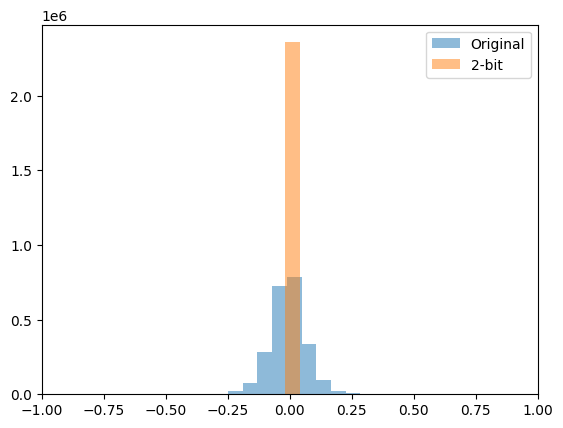

KL Divergence: 0.006750397456343222
KL Divergence: 17.704822635573848
KL Divergence: 24.204427696510965


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Example: Plot histograms
plt.hist(weight_full_precision.flatten().detach().numpy(), bins=50, alpha=0.5, label="Original")
# plt.hist(weight_8bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="8-bit")
# plt.hist(weight_4bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="4-bit")
plt.hist(weight_2bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="2-bit")
plt.legend()
plt.xlim(-1, 1)
plt.show()

def compute_kl_divergence(original, quantized, bins=50, epsilon=1e-10):
    hist_original, _ = np.histogram(original, bins=bins, density=True)
    hist_quantized, _ = np.histogram(quantized, bins=bins, density=True)
    
    # Add epsilon to avoid zero probabilities
    hist_original = hist_original + epsilon
    hist_quantized = hist_quantized + epsilon
    
    # Normalize to ensure valid probability distributions
    hist_original = hist_original / np.sum(hist_original)
    hist_quantized = hist_quantized / np.sum(hist_quantized)
    
    return entropy(hist_original, hist_quantized)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_8bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_4bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_2bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

In [16]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_full_precision.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_full_precision.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_full_precision.mean().item())

Max value of the first layer of the transformer blocks:
2.4307639598846436

Min value of the first layer of the transformer blocks:
-3.06199312210083

Average of the first layer of the transformer blocks:
3.992090205429122e-05


In [22]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_8bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_8bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_8bit.mean().item())
print()

print(f"Average difference between 8-bit version and full precision:")
print(torch.abs(block_8bit.weight().dequantize() - weight_full_precision).mean().item())

Max value of the first layer of the transformer blocks:
2.4255788326263428

Min value of the first layer of the transformer blocks:
-3.074000835418701

Average of the first layer of the transformer blocks:
3.338760870974511e-05

Average difference between 8-bit version and full precision:
0.005997746717184782


In [21]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_4bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_4bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_4bit.mean().item())
print()

print(f"Average difference between 4-bit version and full precision:")
print(torch.abs(weight_4bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 4-bit version and 8-bit version:")
print(torch.abs(weight_4bit - weight_8bit).mean().item())

Max value of the first layer of the transformer blocks:
2.449594497680664

Min value of the first layer of the transformer blocks:
-3.2661259174346924

Average of the first layer of the transformer blocks:
1.4881919923936948e-05

Average difference between 4-bit version and full precision:
0.04256489500403404

Average difference between 4-bit version and 8-bit version:
0.042156487703323364


In [20]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_2bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_2bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_2bit.mean().item())
print()

print(f"Average difference between 2-bit version and full precision:")
print(torch.abs(weight_2bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 2-bit version and 8-bit version:")
print(torch.abs(weight_2bit - weight_8bit).mean().item())
print()

print(f"Average difference between 2-bit version and 4-bit version:")
print(torch.abs(weight_2bit - weight_4bit).mean().item())

Max value of the first layer of the transformer blocks:
2.0413286685943604

Min value of the first layer of the transformer blocks:
-4.082657337188721

Average of the first layer of the transformer blocks:
-1.7304555512964725e-06

Average difference between 2-bit version and full precision:
0.0428580567240715

Average difference between 2-bit version and 8-bit version:
0.042456429451704025

Average difference between 2-bit version and 4-bit version:
0.001149368821643293


In [24]:
import dynamic_quantization as dq

default_dynamic = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Embedding, torch.nn.Conv2d}, dtype=torch.quint8, inplace=True
    )

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Linear, torch.nn.LayerNorm, torch.nn.Conv2d}, dtype=torch.qint8, inplace=True
    )

print("Size after quantization:")
print_size_of_model(default_dynamic)
print(default_dynamic)

Size after quantization:
Size (MB): 122.099212
ViLTransformerSS(
  (text_embeddings): BertEmbeddings(
    (word_embeddings): QuantizedEmbedding(num_embeddings=30522, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (position_embeddings): QuantizedEmbedding(num_embeddings=40, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (quant): QuantStub()
    (dequant): DeQuantStub()
  )
  (token_type_embeddings): QuantizedEmbedding(num_embeddings=3, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32),

In [72]:
import dynamic_quantization as dq

custom_8bit = copy.deepcopy(model)
custom_8bit = dq.quantize_model_dynamic(custom_8bit, 8)

print("Size after quantization:")
print_size_of_model(custom_8bit)
# print(model_dynamic)

======== Quantizing the model DYNAMIC =========
Size after quantization:
Size of the model (MB): 122.099212


# Numeric Suite Analysis

In [73]:
import torch.quantization._numeric_suite as ns

def compute_error(x, y):
    """
    Signal to Noise Ratio (SNR)    
    """
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

## Dynamic Model

In [74]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), custom_8bit.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [81]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [82]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(custom_8bit), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [83]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.60
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.39
5 - transformer.blocks.0.attn.proj.stats
5 - -2.19
6 - transformer.blocks.0.norm2.stats
6 - -1.20
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.85
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.46
9 - transformer.blocks.1.norm1.stats
9 - -1.73
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.21
11 - transformer.blocks.1.attn.proj.stats
11 - -1.97
12 - transformer.blocks.1.norm2.stats
12 - -0.67
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.16
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.57
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.13
17 - transformer.blocks.2.attn.proj.stats
17 - -2.05
18 - transformer.blocks.2.norm2.stats
18 - -0.66
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.54
20 - transformer.bloc

# 8-bit

In [84]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_8.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [85]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_8), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [88]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.87
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.13
5 - transformer.blocks.0.attn.proj.stats
5 - -2.44
6 - transformer.blocks.0.norm2.stats
6 - -1.42
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.71
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.41
9 - transformer.blocks.1.norm1.stats
9 - -1.86
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.06
11 - transformer.blocks.1.attn.proj.stats
11 - -2.14
12 - transformer.blocks.1.norm2.stats
12 - -0.78
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.07
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.65
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.03
17 - transformer.blocks.2.attn.proj.stats
17 - -2.07
18 - transformer.blocks.2.norm2.stats
18 - -0.73
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.47
20 - transformer.bloc

## 4-bit Model

In [89]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_4.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 4.57
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.87
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 3.18
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 7.66
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 4.76
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 3.51
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.10
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 9.37
16 - trans

In [90]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [91]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_4), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [92]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 14.32
1 - text_embeddings.quant.stats
1 - 14.07
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.89
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.17
5 - transformer.blocks.0.attn.proj.stats
5 - -0.62
6 - transformer.blocks.0.norm2.stats
6 - -1.70
7 - transformer.blocks.0.mlp.fc1.stats
7 - 2.84
8 - transformer.blocks.0.mlp.fc2.stats
8 - -0.42
9 - transformer.blocks.1.norm1.stats
9 - -2.18
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.19
11 - transformer.blocks.1.attn.proj.stats
11 - -3.70
12 - transformer.blocks.1.norm2.stats
12 - -1.32
13 - transformer.blocks.1.mlp.fc1.stats
13 - 2.90
14 - transformer.blocks.1.mlp.fc2.stats
14 - -0.18
15 - transformer.blocks.2.norm1.stats
15 - -2.15
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.48
17 - transformer.blocks.2.attn.proj.stats
17 - -1.89
18 - transformer.blocks.2.norm2.stats
18 - -1.27
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.55
20 - transformer.bloc

## 2-bit

In [93]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_2.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.39
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.07
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.04
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.03
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.32
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.03
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.04
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.03
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.27
16 - trans

In [94]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_2), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [95]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 3.22
1 - text_embeddings.quant.stats
1 - -0.85
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.04
4 - transformer.blocks.0.attn.qkv.stats
4 - 4.84
5 - transformer.blocks.0.attn.proj.stats
5 - 0.19
6 - transformer.blocks.0.norm2.stats
6 - -1.89
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.47
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.06
9 - transformer.blocks.1.norm1.stats
9 - -2.27
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.57
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.63
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.43
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.29
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.54
17 - transformer.blocks.2.attn.proj.stats
17 - -0.06
18 - transformer.blocks.2.norm2.stats
18 - -1.64
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.72
20 - transformer.blocks.2.

## 1-bit

In [96]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_1.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.00
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.00
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.00
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.00
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.00
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.00
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.00
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.00
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.00
16 - trans

In [97]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_1), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [98]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 2.06
1 - text_embeddings.quant.stats
1 - -12.40
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.05
4 - transformer.blocks.0.attn.qkv.stats
4 - 5.05
5 - transformer.blocks.0.attn.proj.stats
5 - 0.34
6 - transformer.blocks.0.norm2.stats
6 - -1.95
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.40
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.03
9 - transformer.blocks.1.norm1.stats
9 - -2.34
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.93
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.64
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.30
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.38
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.82
17 - transformer.blocks.2.attn.proj.stats
17 - 0.04
18 - transformer.blocks.2.norm2.stats
18 - -1.67
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.29
20 - transformer.blocks.2.